# Lista 1

Disciplina: ELE08624 - Tópicos Especiais em Processamento de Imagens

Semestre: 2020/1 - especial

Aluno: Gabriel Carvalho Benedito

Matrícula: 2013100874

## Imports

In [13]:
# imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import image, colors
from matplotlib.ticker import PercentFormatter
import numpy as np

## Funções personalizadas

In [83]:
# NOTE: all custom function assumes normalized images on range [0, 1]

# plots an grayscale image
def plot_img(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# plots input and output images
def plot_img_in_ou(img_in, img_out):
    fig, axs = plt.subplots(1, 2)
    # input image
    axs[0].imshow(img_in, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Entrada')
    axs[0].axis('off')
    # output image
    axs[1].imshow(img_out, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Saída')
    axs[1].axis('off');

# plots an frequency and density histogram
def plot_hist(img, n_bins=30):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Histograma')
    plt.subplots_adjust(wspace=0.39)
    # vetorize image (transform to 1D-vector)
    vect_img = np.reshape(img, (-1))
    # stats
    img_mean = np.mean(vect_img)
    img_median = np.median(vect_img)
    mean_label = 'Média = {:.2f}'.format(img_mean)
    median_label = 'Mediana = {:.2f}'.format(img_median)
    # frequencies
    axs[0].hist(vect_img, bins=n_bins)
    axs[0].axvline(img_mean, c='g', label=mean_label)
    axs[0].axvline(img_median, c='r', label=median_label)
    axs[0].legend(fontsize='xx-small')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylabel('Número de pixels')
    axs[0].set_xlabel('Intensidade [0, 1]')
    # density
    weights = np.ones_like(vect_img) / vect_img.size
    axs[1].hist(vect_img, bins=n_bins, weights=weights)
    axs[1].axvline(img_mean, c='g', label=mean_label)
    axs[1].axvline(img_median, c='r', label=median_label)
    axs[1].legend(fontsize='xx-small')
    axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axs[1].set_xlim(0, 1)
    axs[1].set_ylabel('Densidade')
    axs[1].set_xlabel('Intensidade [0, 1]')


## Exercício 1

Usando a definição de conectividade de pixels, faça um programa que conte automaticamente o número de palitos de fósforo na imagem [ex_1.jpg](img/ex_1.jpg), informando também a área (número de pixels) de cada um deles. Seu programa deve fornecer a área de cada palito (desconsidere a cabeça dos palitos). Observe que você terá que binarizar a imagem: gere o seu histograma e escolha um valor de limiar para mapear, acima dele, no nível de cinza 255; e abaixo ou igual aele, no nível de cinza 0.

### Imagem de entrada

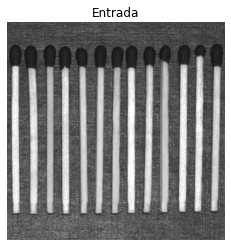

In [15]:
# open image
img = image.imread('img/ex_1.jpg')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Histograma

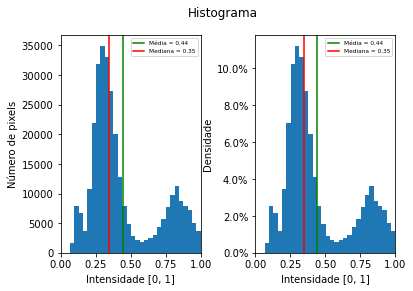

In [16]:
plot_hist(img)

In [17]:
# sigmoif intensity transform
# sig = lambda x, r: 1 / (1 + np.exp(-r * np.tan(np.pi * (x - 1/2))))
# sig_func = np.vectorize(sig)

In [18]:
# img_int_t = sig_func(img, 2)
# plot_hist(img_int_t)

## Exercício 2

Use a técnica de fatiamento de níveis de intensidade para realçar a aorta da figura [ex_2.jpg](img/ex_2.jpg).

### Imagem de entrada

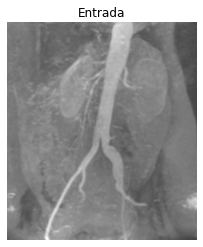

In [19]:
# open image
img = image.imread('img/ex_2.jpg')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Histograma

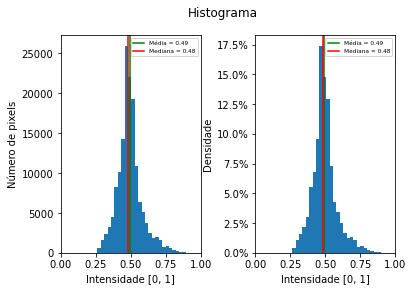

In [20]:
plot_hist(img)

### Fatiamento de níveis de intensidade 

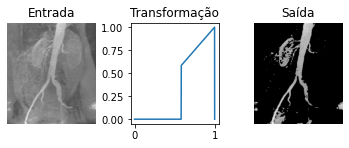

In [21]:
# itensity transform
y = lambda x, min_val, max_val: x if (x > min_val and x < max_val) else 0.
y = np.vectorize(y)

# transform arguments
min_val = .582
max_val = 1.

# apply transform
out_img = y(img, min_val, max_val)

# plots
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4)
# input image
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Entrada')
axs[0].axis('off')
# itensity transform graph
x = np.linspace(0., 1., num=1000)
axs[1].plot(x, y(x, min_val, max_val))
axs[1].set_title('Transformação')
axs[1].set_aspect(img.shape[0]/img.shape[1])
# output image
axs[2].imshow(out_img, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Saída')
axs[2].axis('off');

## Exercício 3

Implemente: a) uma função que realiza a equalização de histograma, b) uma função para obter uma imagem de saída cujo histograma seja da forma mostrada na figura abaixo. Aplique ambas as funções sobre as figuras [ex_3_0.jpg](img/ex_3_0.jpg) e [ex_3_1.jpg](img/ex_3_1.jpg). Discuta os resultados avaliando os histogramas. Calcule a média amostral e a variância amostral das imagens, antes e após a aplicação das funções. Mostre, para cada caso, o histograma antes e depois da aplicação do método. É possível relacionar os resultados com as imagens? Explique.

![alt text](img/ex_3_p.png)

## Exercício 4

Faça uma rotina que implemente uma máscara de convolução espacial de dimensão NxN (N ímpar). Discuta as soluções de tratamento de bordas. Depois, teste as rotinas implementadas na imagem [ex_4.tif](img/ex_4.tif), para os seguintes casos: a) filtro passa-baixas, b) filtro laplaciano, c) filtro de Sobel. Exiba os resultados e comente-os.

#### Considerações sobre a convolução matriz-matriz:

Seja `X` uma matriz `A x B` e `Y` uma matriz `C x D`, expressamos a convolução matriz-matriz `X * Y` por:

- `Z = X * Y`

on `Z` é uma matriz `E x F` cujas dimensões são dadas por:

- `E = A - C + 1`
- `F = B - D + 1`

### Rotina de aplicação de máscara de convolução espacial

In [ ]:
def spatial_conv(a, kernel_func, kernel_size=1, padding=False, mode='constant', **kwargs):
    # neighborhood range of kernel along each axis, considering a central pixel and without conting it
    kernel_offset = int((kernel_size - 1) / 2)
    # compute input
    if not padding:
        # just copy
        a_in = np.copy(a)
    else:
        # pad width
        pad_width = kernel_offset
        # apply padding given numpy possibilities
        a_in = np.pad(a, pad_width, mode, **kwargs)
    # initialize output
    b_out_shape = (a_in.shape[0] - kernel_size + 1, a_in.shape[1] - kernel_size + 1)
    b_out = np.empty(b_out_shape, dtype=a_in.dtype)
    # iterate over rows and coluns
    for r_out, r_in in enumerate(range(kernel_offset, a_in.shape[0] - kernel_offset)):
        for c_out, c_in in enumerate(range(kernel_offset, a_in.shape[1] - kernel_offset)):
            # kernel as neighborhood of input
            kernel = a_in[r_in-kernel_offset:r_in+kernel_offset+1, c_in-kernel_offset:c_in+kernel_offset+1]
            b_out[r_out, c_out] = kernel_func(kernel)
            # apply kernel function
    return b_out



### Imagem de entrada

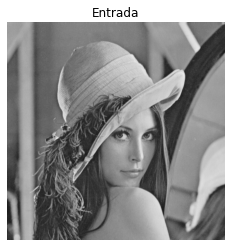

In [25]:
# open image
img = image.imread('img/ex_4.tif')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Soluções de tratamento de bordas

TODO

### Filtro passa-baixas

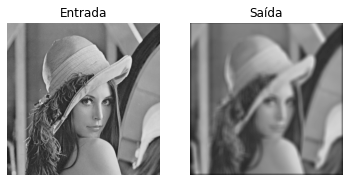

In [89]:
# mean filter on a 15x15 kernel padding input and filling it with zeroes
img_out = spatial_conv(img, lambda x: np.mean(x), kernel_size=15, padding=True)

# plots
plot_img_in_ou(img, img_out)

### Filtro laplaciano

In [ ]:
def ilf(x):
    mid_index = int((x.shape[0]-1)/2)
    return np.diff(x, n=2, axis=0)[mid_index, mid_index] + np.diff(x, n=2, axis=1)[mid_index, mid_index]

# mean filter on a 15x15 kernel padding input and filling it with zeroes
img_out = spatial_conv(img, ilf, kernel_size=15, padding=True)
print(img_out.shape)
# plots
plot_img_in_ou(img, img_out)

In [94]:
# isotropic laplacian filter
ilf = lambda x: np.diff(x, n=2, axis=0) + np.diff(x, n=2, axis=1)
# mean filter on a 15x15 kernel padding input and filling it with zeroes
img_out = spatial_conv(img, ilf, kernel_size=15, padding=True)

# plots
plot_img_in_ou(img, img_out)

(15, 15)


ValueError: operands could not be broadcast together with shapes (13,15) (15,13) 

### Filtro de Sobel

In [ ]:
# mean filter on a 15x15 kernel padding input and filling it with zeroes
img_out = spatial_conv(img, lambda x: np.mean(x), kernel_size=15, padding=True)

# plots
plot_img_in_ou(img, img_out)

## Exercício 5

Reduza a imagem [ex_5.png](img/ex_5.png) eliminando alternadamente as linhas e colunas. Compare a imagem original com a reduzida. O que aconteceu com ela? Ela possui a mesma aparência? Por que isso aconteceu? Que procedimento você poderia aplicar para reduzir esse efeito? Aplique a solução imaginada para evitar esse efeito na imagem reduzida. Compare a nova imagem com as outras duas e avalie o resultado.

## Exercício 6

Faça uma rotina que implemente, no domínio da frequência, um filtro passa baixa de Butterworth de ordem n e frequência de corte D0. Aplique esse filtro com n = 1 sobre a imagem [ex_6.tif](img/ex_6.tif) para dois valores de frequência de corte. Aplique novamente o filtro sobre a mesma imagem e mesmas frequências de corte, mas com n = 8. Comente os resultados.

## Exercício 7

Observar que a fase da transformada de Fourier contém muita informação sobre a imagem. Para isto, tome as imagens [ex_7_0.tif](img/ex_7_0.tif) e [ex_7_1.tiff](img/ex_7_1.tiff), obtenha suas transformadas, troque a componente de fase de cada uma delas e obtenha as inversas. Avalie os resultados.

## Exercício 8

Para as imagens [ex_8_0.tif](img/ex_8_0.tif) e [ex_8_1.tif](img/ex_8_1.tif), aplique os filtros média 5x5, mediana 5x5 e filtro adaptativo de mediana, com tamanho máximo 7x7, para tratar o ruído. Compare com a imagem [ex_8_gt.tif](img/ex_8_gt.tif) calculando-se a PSNR (Peak Signal to Noise Ratio) segundo a equação:

![alt text](img/ex_8_p_0.png)

onde

![alt text](img/ex_8_p_1.png)

I(i,j) e K(i.j) são as imagens originais e as ruidosas, respectivamente, e MAX é o maior valor de nível de cinza, sendo = 255. Usar log10 para calcular a PSNR. Compare os resultados e discuta.

## Perguntas

### 1) Explique como é o procedimento de amostragem e quantização deuma imagem. Explique os problemas relacionados com a resolução espacial e de intensidade.

### 2) Explique o procedimento para ampliar uma imagem N1 x M1 para uma imagem N2 x M2 (N2 > N1, M1 > M2). Quais são os métodos para estimar os valores de pixels desconhecidos?

### 3) Como você explicaria frequência espacial em uma imagem?

### 4) Qual é o procedimento a ser realizado (sequência de etapas) se quisermos realizar uma filtragem no domínio espacial? Imagine, por exemplo, uma imagem de 512x512 e queremos filtrá-la usando uma máscara de dimensões 3x3, qual seria o procedimento?

### 5) Se não for feito o preenchimento de zeros na borda da imagem, qual seráo resultado (saída) de uma imagem filtrada no domínio do espaço por um filtro de média de mesmas dimensões da imagem?Explique a sua resposta.

### 6) Qual é a diferença entre os termos DFT e DTFT? Explique/Comente suas implicações.

### 7) Comente três formas possíveis para estimar a função de degradação em uma imagem degradada.